### Data Analysis Pipeline

- **Create Simulation**: Represent recent and moderate selection.
- **Leverage Pre-trained Model**: Use a model trained on recent and strong selection with high accuracy. Model can be considered trained if Validation acc 70-75% and above
- **Test Trained Model**: Apply to the genomic region of interest to gather posterior probabilities.
- **Training Regimen**:
  - Train for 27 epochs.
  - 3 epochs each from batches 1-9 of training data.
  - Test on the final batch of unseen data.
- **Preliminary Testing**:
  - Focus on the C/T(-13910) variant (rs4988235) located on chromosome 2 in the MCM6 gene, influencing the lactase (LCT) gene.
  - This SNP is associated with lactose intolerance in European populations, with the T allele indicating lactase persistence.
  - Extract SNP information from an 80k base pair region around rs4988235 using 1000 Genomes Project data for all unrelated individuals of CEU population (European descent).
  - Data is provided in VCF file format.



In [1]:
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Navigate to the cloned repository
%cd EvoNet-CNN-Insight/model_training/recent_moderate

Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 4732, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 4732 (delta 157), reused 277 (delta 98), pack-reused 4379
Receiving objects: 100% (4732/4732), 5.95 GiB | 27.26 MiB/s, done.
Resolving deltas: 100% (1748/1748), done.
Updating files: 100% (51/51), done.
/content/EvoNet-CNN-Insight/model_training/recent_moderate


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model

# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


Run ImaGene.py

In [3]:
%run -i ../../ImaGene.py

In [4]:
#run to make simulations
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_recent_moderate.txt".split());

 the first iteration of training.


In [5]:

path_sim = './'

In [6]:
file_sim = ImaFile(simulations_folder=path_sim + 'RM/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain.
As a quick example, we will use only 2000 data points per class.

In [7]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000);

We can have a look at the data stored in this object.

In [8]:
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 230, max 471, mean 341.243000, std 35.079067


In [9]:
# Filter simulations based on frequency threshold of 0.01
gene_sim.filter_freq(0.01)

# Sort simulations by row frequency
gene_sim.sort('rows_freq')

# Provide summary of the simulation data
gene_sim.summary()


An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 156, max 378, mean 253.877000, std 32.596117


0

In [10]:
# Resize simulation data to (198, 192)
gene_sim.resize((198, 192))

# Provide summary of the simulation data
gene_sim.summary()


An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

In [11]:
# Convert simulation data with data augmentation (flip)
gene_sim.convert(flip=True)

# Provide summary of the simulation data
gene_sim.summary()


An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

information on the corresponding targets (in this case the selection coefficient, either 0 or selection coefficient of choice in $2N_e$ units with $N_e = 10000$).

0


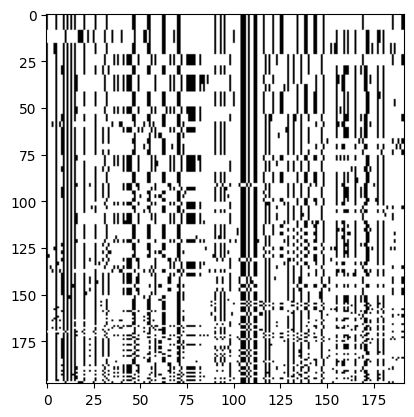

200


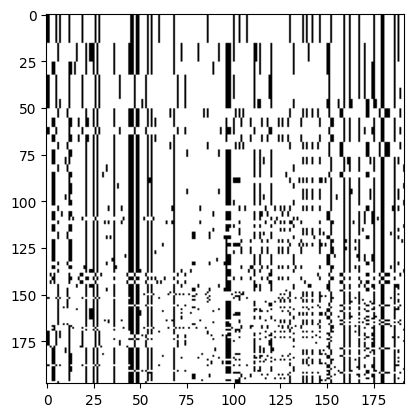

In [12]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [13]:
# Subset the simulation data with random indices
gene_sim.subset(get_index_random(gene_sim))

# Convert targets to binary format
gene_sim.targets = to_binary(gene_sim.targets)


In [14]:

# Load the pre-trained model from the parent directory
base_model = load_model('../RS.binary.h5')

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained model for fine-tuning
model = models.Sequential([
    base_model,  # The pre-trained model is added as the base
    layers.Flatten(),  # Flatten the output from the base model to feed into dense layers
    layers.Dense(units=128, activation='relu'),  # New dense layer with 128 units and ReLU activation
    layers.Dropout(0.5),  # Dropout for regularization to prevent overfitting
    layers.Dense(units=1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with an adjusted learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model to show its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 4173473   
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 128)               256       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4173858 (15.92 MB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 4173473 (15.92 MB)
_________________________________________________________________


In [15]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=3, verbose=1, validation_split=0.10)

Epoch 1/3
29/29 [==============================] - 32s 1s/step - loss: 0.9562 - accuracy: 0.5011 - val_loss: 0.9531 - val_accuracy: 0.5050
Epoch 2/3
29/29 [==============================] - 27s 947ms/step - loss: 0.9543 - accuracy: 0.4972 - val_loss: 0.9507 - val_accuracy: 0.5050
Epoch 3/3
29/29 [==============================] - 31s 1s/step - loss: 0.9522 - accuracy: 0.5061 - val_loss: 0.9483 - val_accuracy: 0.5950


In [16]:
net_LCT = ImaNet(name='[BaseModel]+D128')

In [17]:
net_LCT.update_scores(score);

2
Epoch 1/3
29/29 [==============================] - 25s 871ms/step - loss: 0.9501 - accuracy: 0.6056 - val_loss: 0.9515 - val_accuracy: 0.6550
Epoch 2/3
29/29 [==============================] - 27s 921ms/step - loss: 0.9478 - accuracy: 0.6139 - val_loss: 0.9499 - val_accuracy: 0.4150
Epoch 3/3
29/29 [==============================] - 25s 878ms/step - loss: 0.9456 - accuracy: 0.6217 - val_loss: 0.9484 - val_accuracy: 0.4950
3
Epoch 1/3
29/29 [==============================] - 30s 1s/step - loss: 0.9447 - accuracy: 0.5767 - val_loss: 0.9371 - val_accuracy: 0.8200
Epoch 2/3
29/29 [==============================] - 30s 1s/step - loss: 0.9434 - accuracy: 0.7656 - val_loss: 0.9350 - val_accuracy: 0.8050
Epoch 3/3
29/29 [==============================] - 32s 1s/step - loss: 0.9419 - accuracy: 0.7811 - val_loss: 0.9331 - val_accuracy: 0.8000
4
Epoch 1/3
29/29 [==============================] - 26s 899ms/step - loss: 0.9380 - accuracy: 0.7756 - val_loss: 0.9484 - val_accuracy: 0.7700
Epoch 2/3

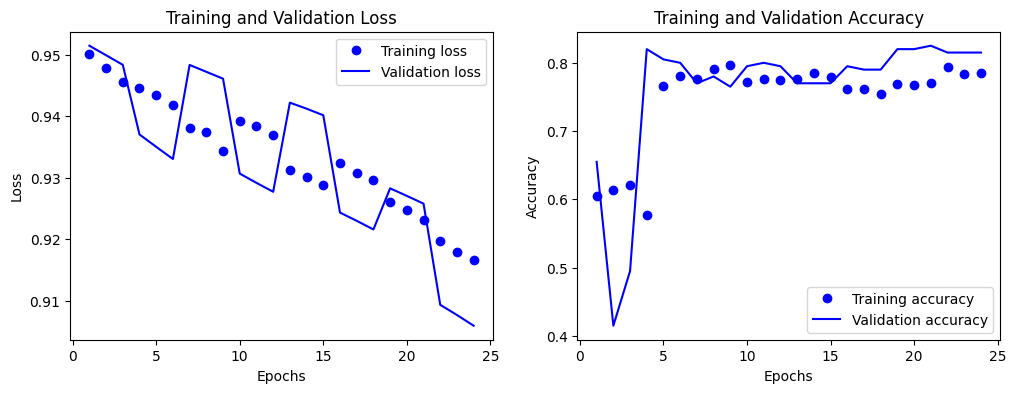

In [18]:
i = 2
all_scores = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Loop to iterate through different simulation datasets
while i < 10:
    print(i)

    # Create ImaFile object for the specified simulation folder and model
    file_sim = ImaFile(simulations_folder=path_sim + 'RM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    # Read the simulation data
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    # Filter simulations based on frequency threshold
    gene_sim.filter_freq(0.01)

    # Sort simulations by row frequency
    gene_sim.sort('rows_freq')

    # Resize simulation data to the required dimensions
    gene_sim.resize((198, 192))

    # Convert simulation data (flip=True allows for data augmentation)
    gene_sim.convert(flip=True)

    # Get a random subset of indices and subset the simulation data
    gene_sim.subset(get_index_random(gene_sim))

    # Convert targets to binary format
    gene_sim.targets = to_binary(gene_sim.targets)

    # Train the model on the current subset of simulation data
    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=3, verbose=1, validation_split=0.10)

    # Update scores with the current training results
    all_scores['loss'].extend(score.history['loss'])
    all_scores['val_loss'].extend(score.history['val_loss'])
    all_scores['accuracy'].extend(score.history['accuracy'])
    all_scores['val_accuracy'].extend(score.history['val_accuracy'])

    # Increment the index for the next iteration
    i += 1

# Define the number of epochs for plotting
epochs = range(1, len(all_scores['loss']) + 1)

# Create a figure for plotting
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, all_scores['loss'], 'bo', label='Training loss')
plt.plot(epochs, all_scores['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, all_scores['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, all_scores['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()

In [20]:
# Set the appropriate path
path = './'
# Save the trained model to a file
model.save(path + 'RM.binary.h5')

# Load the model from the saved file
model = load_model(path + 'RM.binary.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluate the training on the testing dataset, Which is the last batch of the the 10th simulation in the file
The log the testing validation and loss alongside the F1,

In [21]:
# Set the simulation index
i = 10

# Create an ImaFile object for the specified simulation folder and model
file_sim = ImaFile(simulations_folder=path_sim + 'RM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

# Read the simulation data with the specified parameter and maximum number of replicates
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

# Filter the simulations based on a frequency threshold of 0.01
gene_sim_test.filter_freq(0.01)

# Sort the simulations by row frequency
gene_sim_test.sort('rows_freq')

# Resize the simulation data to the specified dimensions (198, 192)
gene_sim_test.resize((198, 192))

# Convert the simulation data with data augmentation (flip=True)
gene_sim_test.convert(flip=True)

# Get a random subset of indices and subset the simulation data
rnd_idx = get_index_random(gene_sim_test)  # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

# Convert the targets to binary format
gene_sim_test.targets = to_binary(gene_sim_test.targets)


In [22]:
# Evaluate the model on the test data to obtain loss and accuracy
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)

# Print the evaluation results, which include loss and accuracy
print(net_LCT.test)  # It will report [loss, accuracy]


[0.916624903678894, 0.7680000066757202]


63/63 [==============================] - 28s 430ms/step


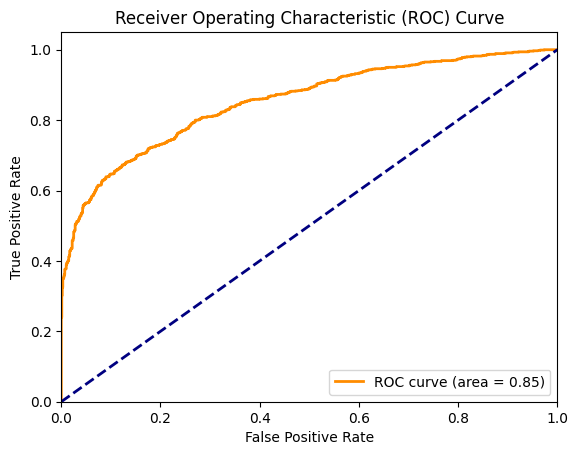

F1 Score: 0.7234803337306317
Precision: 0.8952802359882006
Recall (Sensitivity): 0.607


In [23]:
# Make predictions on the validation data
predictions = model.predict(gene_sim_test.data)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, predictions.round())

# Calculate precision, recall, and F-score
precision, recall, fscore, _ = precision_recall_fscore_support(gene_sim_test.targets, predictions.round(), average='binary')

# Recall is equivalent to sensitivity
sensitivity = recall

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print additional metrics
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {sensitivity}')

63/63 [==============================] - 23s 360ms/step


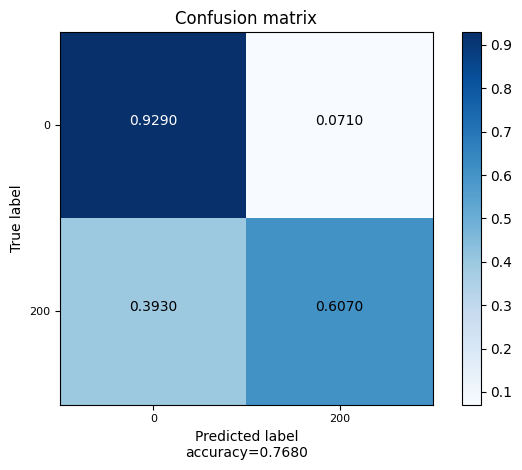

0

In [24]:
# Make predictions on the test data using the trained model and store the results in net_LCT
net_LCT.predict(gene_sim_test, model)

# Plot the confusion matrix of the predictions against the true classes, with text labels for clarity
net_LCT.plot_cm(gene_sim_test.classes, text=True)


### 4. Deploy the trained network on Genomic regions

In [25]:
# Create an ImaFile object for the LCT gene data with 198 samples, specifying the VCF file path
file_LCT = ImaFile(nr_samples=198, VCF_file_name='../../LCT.CEU.vcf')

# Read the VCF file to get the gene data
gene_LCT = file_LCT.read_VCF()

# Provide summary of the gene data
gene_LCT.summary()


An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 2200, max 2200, mean 2200.000000, std 0.000000


0

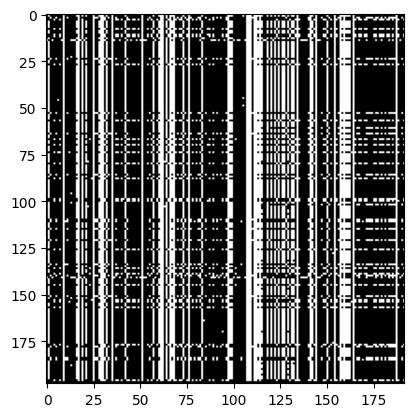

0

In [26]:
# Filter the gene data based on a frequency threshold of 0.01
gene_LCT.filter_freq(0.01)

# Plot the filtered gene data
gene_LCT.plot()


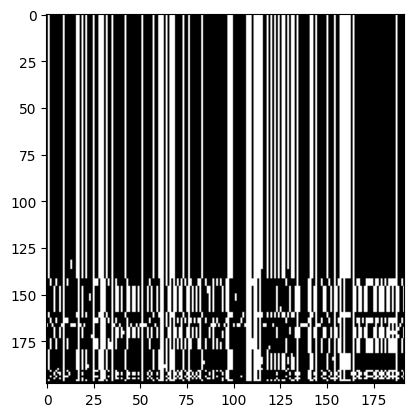

0

In [27]:
# Sort the gene data by row frequency
gene_LCT.sort('rows_freq')

# Plot the sorted gene data
gene_LCT.plot()


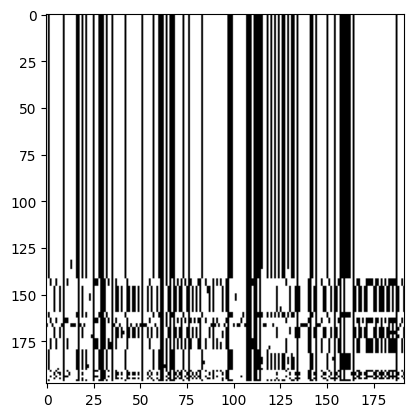

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

In [28]:
# Convert gene data with data augmentation (flip)
gene_LCT.convert(flip=True)

# Plot the converted gene data
gene_LCT.plot()

# Provide summary of the gene data
gene_LCT.summary()


In [29]:
# Make predictions on the gene data and print the first prediction
print(model.predict(gene_LCT.data, batch_size=None)[0][0])


1/1 [==============================] - 0s 32ms/step
0.76857287
